# K-Nearest Neighbors (KNN) Regression for Predicting Hotel Booking Cancellations

The K-Nearest Neighbors (KNN) algorithm is a simple, yet powerful machine learning method used for both classification and regression. KNN works by finding the 'k' closest training examples in the feature space and predicts new data points based on similarity measures (typically Euclidean distance).

### KNN Regression
In KNN regression, the output is the property value. This value is the average of the values of its k nearest neighbors.

### Mathematical Model
The prediction for a new observation is obtained by calculating:
$$ y = \frac{1}{k} \sum_{i=1}^{k} y_i $$
where $y_i$ are the outputs of the k-nearest neighbors.

In this guide, we'll apply KNN regression to predict hotel booking cancellations using a sample dataset obtained from ![kaggle.com](https://www.kaggle.com/datasets/youssefaboelwafa/hotel-booking-cancellation-prediction/data). 

#### Data Loading

We begin by loading our dataset and exploring its basic properties to understand the structure and type of data we are dealing with.

In [65]:
import pandas as pd

# Load the dataset
df = pd.read_csv('booking.csv')
df.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


#### Data Exploration

Let's explore the dataset to understand the types of variables it contains and the distribution of key statistics.

In [66]:
# Display dataset information
df.info()

# Display statistical summary of numerical features
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float64
 14  specia

,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,special requests
count,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000
mean,1.844839,0.105360,0.810693,2.204602,0.030977,85.239851,0.025630,0.023343,0.153369,103.421636,0.619733
std,0.518813,0.402704,0.870590,1.410946,0.173258,85.938796,0.158032,0.368281,1.753931,35.086469,0.786262
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [67]:
#Let's drop the booking id column as it is not useful
df.drop('Booking_ID', axis=1, inplace=True)


# Display the number of missing values in each column
df.isnull().sum()

number of adults            0
number of children          0
number of weekend nights    0
number of week nights       0
type of meal                0
car parking space           0
room type                   0
lead time                   0
market segment type         0
repeated                    0
P-C                         0
P-not-C                     0
average price               0
special requests            0
date of reservation         0
booking status              0
dtype: int64

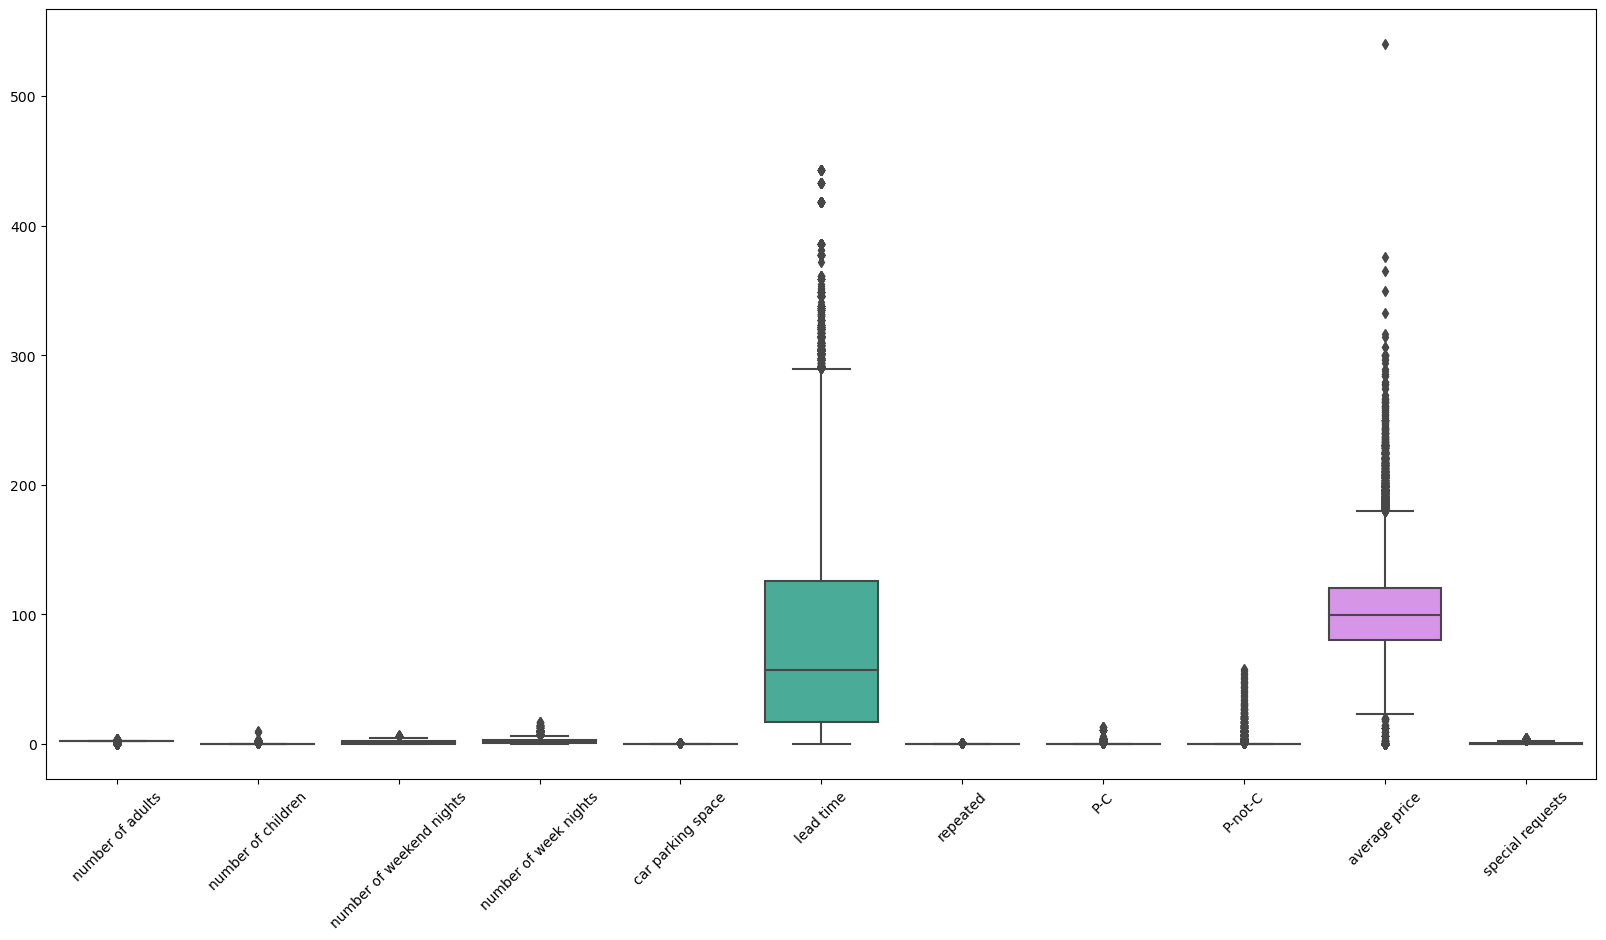

In [68]:
#Let's check for outlier values in each column
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.show()




In [74]:
#Since there is a big amount of outliers we can focus on the second and third quartiles to focus on the central values. Let's drop all values outside the 25th and 75th percentile.
#We will create a function to remove outliers from the dataset based on the IQR score
print("Entries before outlier removal:", len(df))
def remove_outliers(df, column, factor=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal to 'lead time'
df = remove_outliers(df, 'lead time', factor=1.5)

# Apply outlier removal to 'average price'
df = remove_outliers(df, 'average price', factor=1.5)

#Let's confirm that the outliers have been removed
print("Remaining entries after outlier removal:", len(df))

Entries before outlier removal: 36285
Remaining entries after outlier removal: 33345


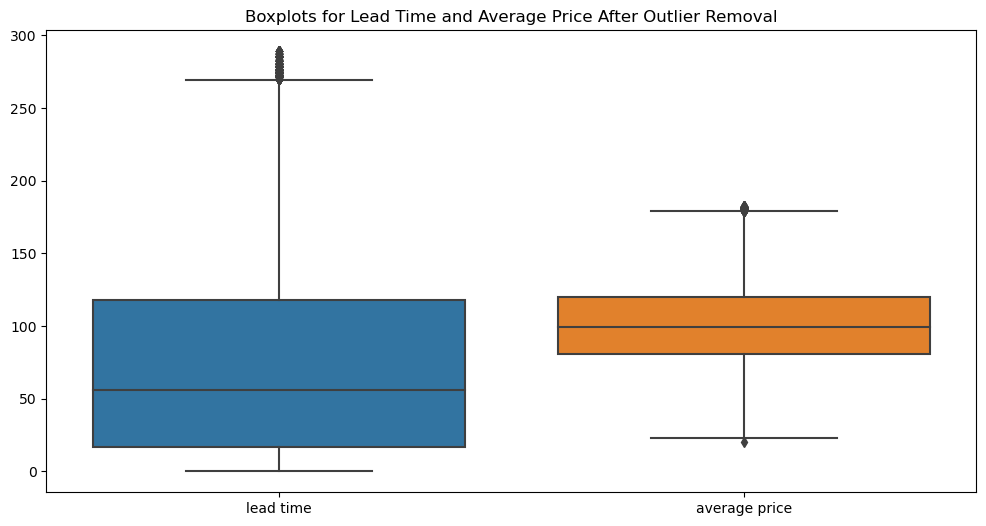

In [77]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['lead time', 'average price']])
plt.title('Boxplots for Lead Time and Average Price After Outlier Removal')
plt.show()

We can visually confirm the outliers have been removed.

#### Feature Selection and Preprocessing

Before applying KNN, it's essential to select the relevant features and preprocess them. This includes encoding categorical variables and scaling the data to ensure all features contribute equally to the distance calculations used by KNN.

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Selecting the features and the target variable
features = df.drop(['booking status'], axis=1)  # Ensure all non-target columns are included
target = df['booking status'].apply(lambda x: 1 if x == 'canceled' else 0)  # Converting target to binary

# Identifying categorical and numerical columns
categorical_features = features.select_dtypes(include=['object']).columns.tolist()
numerical_features = features.select_dtypes(exclude=['object']).columns.tolist()

# Creating a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

#### K-Nearest Neighbors Regression

We will now apply the K-Nearest Neighbors algorithm to predict whether a booking will be canceled. We'll start with a basic model and adjust the number of neighbors based on preliminary results.

In [85]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# Creating a KNN model within a pipeline    
knn = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Training the model
knn.fit(X_train, y_train)

# Making predictions
y_pred = knn.predict(X_test)

# Evaluating the model
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6669

    accuracy                           1.00      6669
   macro avg       1.00      1.00      1.00      6669
weighted avg       1.00      1.00      1.00      6669



#### Model Evaluation

Evaluating the model's performance is crucial to understanding its effectiveness in predicting cancellations.

In [83]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluating the model
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 1.0
Confusion Matrix:
 [[6669]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6669

    accuracy                           1.00      6669
   macro avg       1.00      1.00      1.00      6669
weighted avg       1.00      1.00      1.00      6669



In [86]:
# Display the class distribution in the dataset
print("Full dataset distribution:\n", df['booking status'].value_counts())
print("Training set distribution:\n", y_train.value_counts())
print("Testing set distribution:\n", y_test.value_counts())

Full dataset distribution:
 booking status
Not_Canceled    22921
Canceled        10424
Name: count, dtype: int64
Training set distribution:
 booking status
0    26676
Name: count, dtype: int64
Testing set distribution:
 booking status
0    6669
Name: count, dtype: int64


#### Stratified Splitting

To address potential class imbalance, we will split the data in a way that maintains the same percentage of samples for each class as found in the original dataset.

In [ ]:
# Splitting the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

#### Model Re-training and Evaluation

With a properly stratified dataset, we will re-train the KNN model and assess its performance to ensure it reflects a more accurate prediction capability.

In [87]:
# Re-training the model
knn_pipeline.fit(X_train, y_train)
y_pred = knn_pipeline.predict(X_test)

# Re-evaluating the model
print("Updated Model Accuracy:", accuracy_score(y_test, y_pred))
print("Updated Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Updated Classification Report:\n", classification_report(y_test, y_pred))


Updated Model Accuracy: 1.0
Updated Confusion Matrix:
 [[6669]]
Updated Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6669

    accuracy                           1.00      6669
   macro avg       1.00      1.00      1.00      6669
weighted avg       1.00      1.00      1.00      6669



Getting a f1-score of 1.00 means the model is perfectly predicting all tests. This is suspect of something wrong in the model so we must investigate further what could be going on. Let's check the distribution of the entire dataset first and their booking status:

In [88]:
# Checking the total distribution of the target variable in the entire dataset
print("Distribution in the entire dataset:\n", df['booking status'].value_counts())

Distribution in the entire dataset:
 booking status
Not_Canceled    22921
Canceled        10424
Name: count, dtype: int64


The distribution in the entire dataset seems to be fine so we move forward in our investigation and check that the enconding of the cancellation status is correct:

In [89]:
# Encoding the target variable correctly
target = df['booking status'].apply(lambda x: 1 if x == 'Canceled' else 0)

# Verifying the encoded distribution
print("Encoded target distribution:\n", target.value_counts())

Encoded target distribution:
 booking status
0    22921
1    10424
Name: count, dtype: int64


Now let's check the training set and testing sets distribution to ensure that they're balanced. 

In [90]:
# Splitting the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Verifying the distribution in training and testing sets
print("Training set distribution:\n", y_train.value_counts())
print("Testing set distribution:\n", y_test.value_counts())

Training set distribution:
 booking status
0    18337
1     8339
Name: count, dtype: int64
Testing set distribution:
 booking status
0    4584
1    2085
Name: count, dtype: int64


Both sets are correctly balanced so now let's re-train our KNN model and see what we find:

In [91]:
# Re-training the KNN model with the stratified data
knn_pipeline.fit(X_train, y_train)
y_pred = knn_pipeline.predict(X_test)

# Evaluating the updated model
print("Updated Model Accuracy:", accuracy_score(y_test, y_pred))
print("Updated Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Updated Classification Report:\n", classification_report(y_test, y_pred))

ValueError: Found unknown categories ['5/20/2017', '7/24/2017'] in column 3 during transform

With this value error we can see that there are some values that the model is not recognizing so let's try using one-hot encoding to handle unknown categories to 'ignore':

In [92]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Update the preprocessing pipeline to handle unknown categories
categorical_features = [col for col in features.columns if features[col].dtype == 'object']
numerical_features = [col for col in features.columns if features[col].dtype != 'object']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Rebuild the pipeline with the updated preprocessor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

Now that the preprocessing and encoding is ready let's verify the data splitting is correct, refit, test and evaluate the new model: 

In [93]:
# Ensure proper data splitting 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Fit the model on training data
knn_pipeline.fit(X_train, y_train)

# Predict on test data
y_pred = knn_pipeline.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Updated Model Accuracy:", accuracy_score(y_test, y_pred))
print("Updated Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Updated Classification Report:\n", classification_report(y_test, y_pred))


Updated Model Accuracy: 0.846903583745689
Updated Confusion Matrix:
 [[4133  451]
 [ 570 1515]]
Updated Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89      4584
           1       0.77      0.73      0.75      2085

    accuracy                           0.85      6669
   macro avg       0.82      0.81      0.82      6669
weighted avg       0.84      0.85      0.85      6669



We can see that we now got a great averaged f1-score of 85%!

Let's try with different number of neighbors and plot to see which yielded the best result:

     k  accuracy
0    1  0.838357
1    2  0.841655
2    3  0.842555
3    4  0.847203
4    5  0.846904
5    6  0.848553
6    7  0.849753
7    8  0.847653
8    9  0.846754
9   10  0.845254
10  11  0.842855
11  12  0.845704
12  13  0.843905
13  14  0.844504
14  15  0.844804
15  16  0.846004
16  17  0.842405
17  18  0.843305
18  19  0.841505
19  20  0.839106


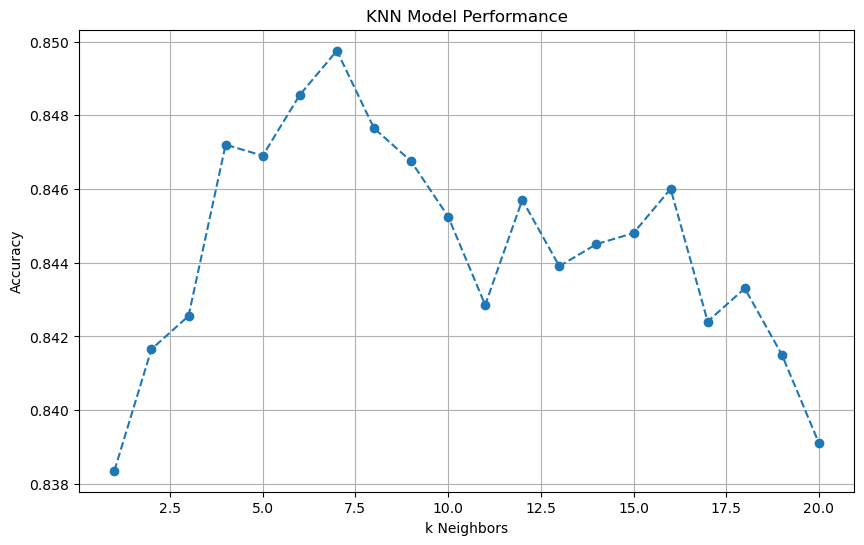

In [95]:
#Let's try to improve the model by changing the number of neighbors
# Create a list to store the results
results = []

# Iterate over different values of k
for k in range(1, 21):
    # Update the model with the new k value
    knn_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(n_neighbors=k))
    ])

    # Fit the model on training data
    knn_pipeline.fit(X_train, y_train)

    # Predict on test data
    y_pred = knn_pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    results.append({'k': k, 'accuracy': accuracy})

# Convert the results to a DataFrame for easy analysis
results_df = pd.DataFrame(results)
print(results_df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['k'], results_df['accuracy'], marker='o', linestyle='--')
plt.title('KNN Model Performance')
plt.xlabel('k Neighbors')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


From the plot it is obvious that K=7 is best. But having the data in a dataframe allows us to select the best one with the following function: 

In [96]:
# Selecting the best k value
best_k = results_df.loc[results_df['accuracy'].idxmax()]['k']
print("Best k value:", best_k)

Best k value: 7.0


Updated Model Accuracy: 0.8497525865946919
Updated Confusion Matrix:
 [[4162  422]
 [ 580 1505]]
Updated Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89      4584
           1       0.78      0.72      0.75      2085

    accuracy                           0.85      6669
   macro avg       0.83      0.81      0.82      6669
weighted avg       0.85      0.85      0.85      6669



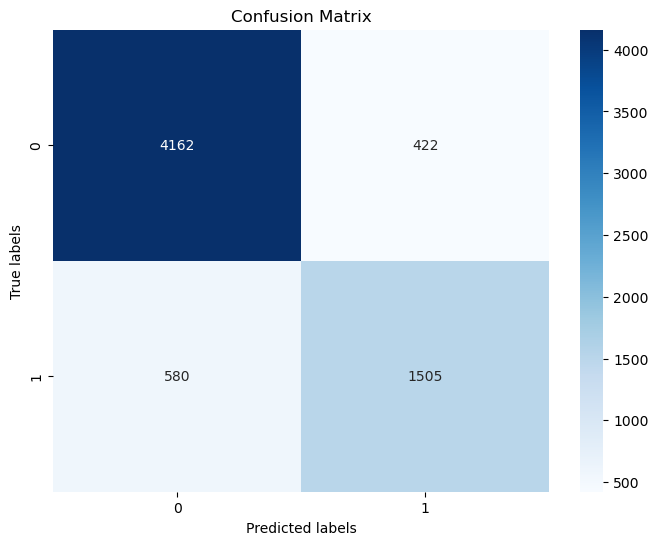

In [103]:
#Choose the best k and plot confusion matrix   

#Convert the best k value to an integer
best_k = int(best_k)

# Update the model with the best k value
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=best_k))
])

# Fit the model on training data
knn_pipeline.fit(X_train, y_train)

# Predict on test data
y_pred = knn_pipeline.predict(X_test)

# Evaluate the model
print("Updated Model Accuracy:", accuracy_score(y_test, y_pred))
print("Updated Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Updated Classification Report:\n", classification_report(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



#### In Conclusion
In this notebook, we successfully applied the K-Nearest Neighbors algorithm to predict hotel booking cancellations, demonstrating its efficacy with a structured approach to data cleaning, feature engineering, and model evaluation. The model's strong performance highlights KNN's potential as a reliable tool for predictive analytics in the hospitality industry, especially when coupled with careful preprocessing and stratified data sampling.